## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree

## Data Preprocessing

First, we read in the dataset.

In [2]:
#| label: dataset-preview
df = pd.read_csv("../data/solar.csv")
df.head(5)

,id,lat,long,state,farm_type,irradiance,lcoe,capacity,capacity_factor,array_area,available_solar_resource,generated_energy,cost
0,0,25.896492,-97.460358,Texas,large_community,5.634079,39,5.00,0.235,90633.862770,21.276596,6132.00,4782960.0
1,1,26.032654,-97.738098,Texas,small_utility,5.616413,39,5.00,0.234,91307.484990,21.367521,6132.00,4782960.0
2,2,26.059063,-97.208252,Texas,small_community,5.746738,39,0.15,0.239,2621.097459,0.627615,183.96,143488.8
3,3,26.078449,-98.073364,Texas,small_utility,5.742196,39,5.00,0.239,87439.036330,20.920502,6132.00,4782960.0
4,4,26.143227,-98.311340,Texas,small_utility,5.817187,39,5.00,0.242,85241.850210,20.661157,6132.00,4782960.0


Now, we must shuffle the datasets to reduce bias.

In [3]:
#| label: shuffled-dataset-preview

df = df.sample(frac=1)
df.head(5)

,id,lat,long,state,farm_type,irradiance,lcoe,capacity,capacity_factor,array_area,available_solar_resource,generated_energy,cost
6903,6903,35.340389,-102.449249,Texas,medium_utility,6.323517,39,500.000,0.263,7.215506e+06,1901.140684,613200.000,4.782960e+08
5455,5455,34.969135,-104.838562,New Mexico,large_community,6.552958,34,5.000,0.273,6.707818e+04,18.315018,6132.000,4.169760e+06
5800,5800,35.222565,-101.987335,Texas,small_residential,6.259271,39,0.005,0.261,7.345426e+01,0.019157,6.132,4.782960e+03
2889,2889,34.300049,-101.105133,Texas,medium_community,6.184820,39,2.000,0.258,3.008115e+04,7.751938,2452.800,1.913184e+06
9752,9752,37.012718,-80.288757,Virginia,small_community,5.146555,46,0.150,0.214,3.268677e+03,0.700935,183.960,1.692432e+05


Looking at each dataset, we can identify which variables we want to use for our models.

In [4]:
X = df.loc[:, ['lat','long','capacity']]
y = df.loc[:, ['generated_energy','cost']]

Now we split into training and testing sets, reserving about 80% for training and 20% for testing.

In [5]:
X_train = X[:9500]
X_test = X[9500:]
y_train = y[:9500]
y_test = y[9500:]

Models typically perform better when input values are within a certain range, like [-1, 1] for example. We scale the data points appropriately.

In [6]:
#| label: scaled-data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 0.05942354, -0.22478554,  0.35692648],
       [-0.03505453, -0.53086542, -0.43588483],
       [ 0.02943926, -0.16561264, -0.44388501],
       ...,
       [-1.65987101,  0.4749176 ,  0.35692648],
       [-0.40675385, -0.96669284, -0.43588483],
       [ 0.11236886,  0.3340536 , -0.44388501]])

## Training the Models

Now that the data is pre-processed accordingly, the models can be trained and fit.

In [7]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

RandomForestRegressor()

With a trained model, predictions can now be made.

In [8]:
#| label: prediction-comparisons

display = y_test.reset_index()
preds = reg.predict(X_test)
print("Predictions")
print("----------------------")
for i in range(3):
    print(f"predicted energy: {preds[i][0]:.2f}\tactual energy: {display.at[i, 'generated_energy']:.2f}\tpredicted cost: {preds[i][1]:.2f}\tactual cost: {display.at[i, 'cost']:.2f}")

Predictions
----------------------
predicted energy: 6132.00	actual energy: 6132.00	predicted cost: 5028240.00	actual cost: 5028240.00
predicted energy: 613200.00	actual energy: 613200.00	predicted cost: 416976000.00	actual cost: 416976000.00
predicted energy: 6132.00	actual energy: 6132.00	predicted cost: 5028240.00	actual cost: 5028240.00


## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

In [9]:
#| label: metrics

r2 = metrics.r2_score(y_test, preds, multioutput="raw_values")
rmse = metrics.root_mean_squared_error(y_test, preds, multioutput="raw_values")
mape = metrics.mean_absolute_percentage_error(y_test, preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"r2\t{r2}\nrmse\t{rmse}\nmape\t{mape}")

Metric	Score
-----------------------
r2	[1.         0.99947801]
rmse	[1.89379452e-12 1.36960035e+07]
mape	[9.69285180e-16 4.32843758e-03]


#### Feature Importances

Feature importances give insights into the features that each decision tree in the random forest use to split most often. Results are portrayed in percentages.

In [10]:
#| label: feature-importances

features = ['lat','long','capacity',]

importances = reg.feature_importances_
indices = np.argsort(importances)

print("Importances")
print('----------------------')
for i in indices:
    print(f"{features[i]}: {importances[i]*100}")

Importances
----------------------
long: 0.49924958098045885
lat: 0.7828307672340137
capacity: 98.71791965178554


#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which are then used to test a model. The model is then scored using the same metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is rigorous, and the *entire* dataset is used.

In [11]:
#| label: k-fold-cross-validation-table

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(reg, X, y, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
means = kf_cv_df.mean()
print("10-Fold Cross Validation Scores")
print("----------------------------------------------------")
print(f"R2 Average: {means.iloc[2]}")
print(f"RMSE Average: {means.iloc[3]}")
print(f"MAPE Average: {means.iloc[4]}")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------
R2 Average: 0.999750656025779
RMSE Average: 6617044.390212841
MAPE Average: 0.0019449076617190596


,fit_time,score_time,test_r2,test_rmse,test_mape
0,1.632876,0.015011,0.999873,4.897471e+06,0.002525
1,1.631738,0.014999,0.999823,5.617429e+06,0.002217
2,1.622672,0.015010,0.999570,8.502769e+06,0.001829
3,1.667683,0.017003,0.999713,7.136015e+06,0.002001
4,1.637736,0.015005,0.999726,7.230096e+06,0.001571
5,1.633425,0.015007,0.999664,7.606358e+06,0.001857
6,1.658941,0.016011,0.999776,6.570015e+06,0.001679
7,1.636302,0.015014,0.999762,6.738053e+06,0.001821
8,1.638819,0.015063,0.999753,6.439429e+06,0.001767
9,1.669811,0.015005,0.999846,5.432810e+06,0.002182


### Graphs

Graphs of the Random Forest model fits on each of the input features, for each target.

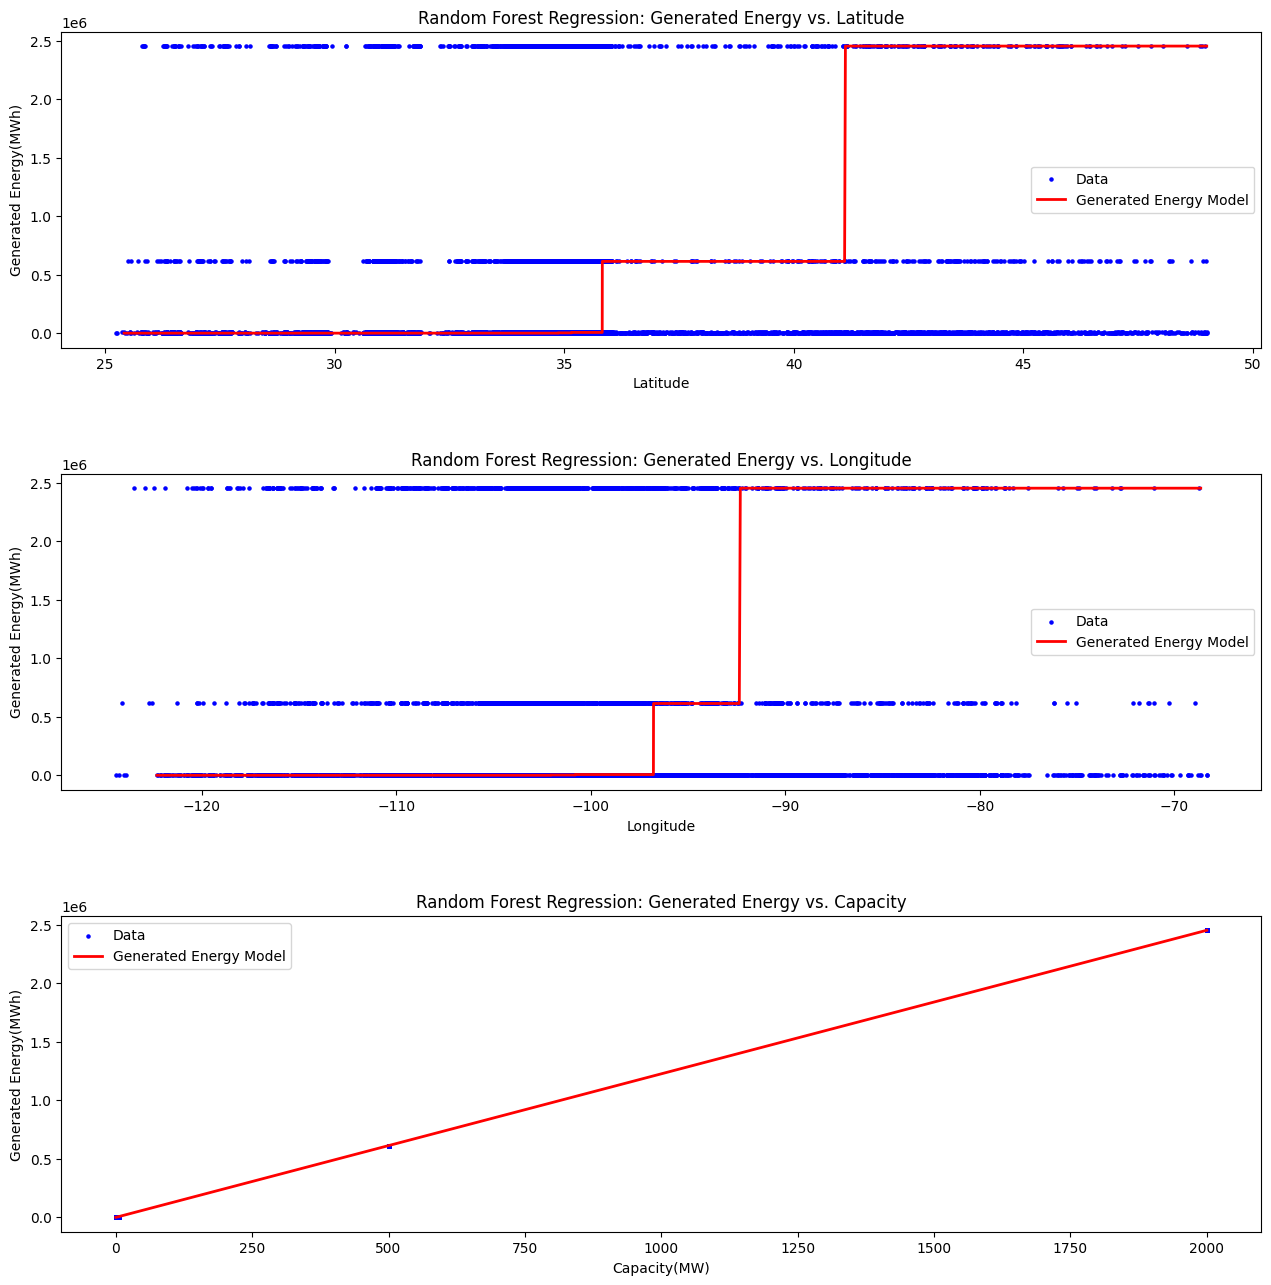

In [16]:
#| label: fig-generated-energy-vs-input-features

plot_lat_x = X[9500:].loc[:,['lat']].sort_values(by=['lat'])
plot_long_x = X[9500:].loc[:,['long']].sort_values(by=['long'])
plot_cap_x = X[9500:].loc[:,['capacity']].sort_values(by=['capacity'])
plot_energy_y = pd.DataFrame(preds).loc[:,[0]].sort_values(by=[0])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Generated Energy(MWh)")
axis[0].set_title("Random Forest Regression: Generated Energy vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Generated Energy(MWh)")
axis[1].set_title("Random Forest Regression: Generated Energy vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y.loc[:,['generated_energy']], color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_energy_y, color='red',lw=2, label="Generated Energy Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Generated Energy(MWh)")
axis[2].set_title("Random Forest Regression: Generated Energy vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()

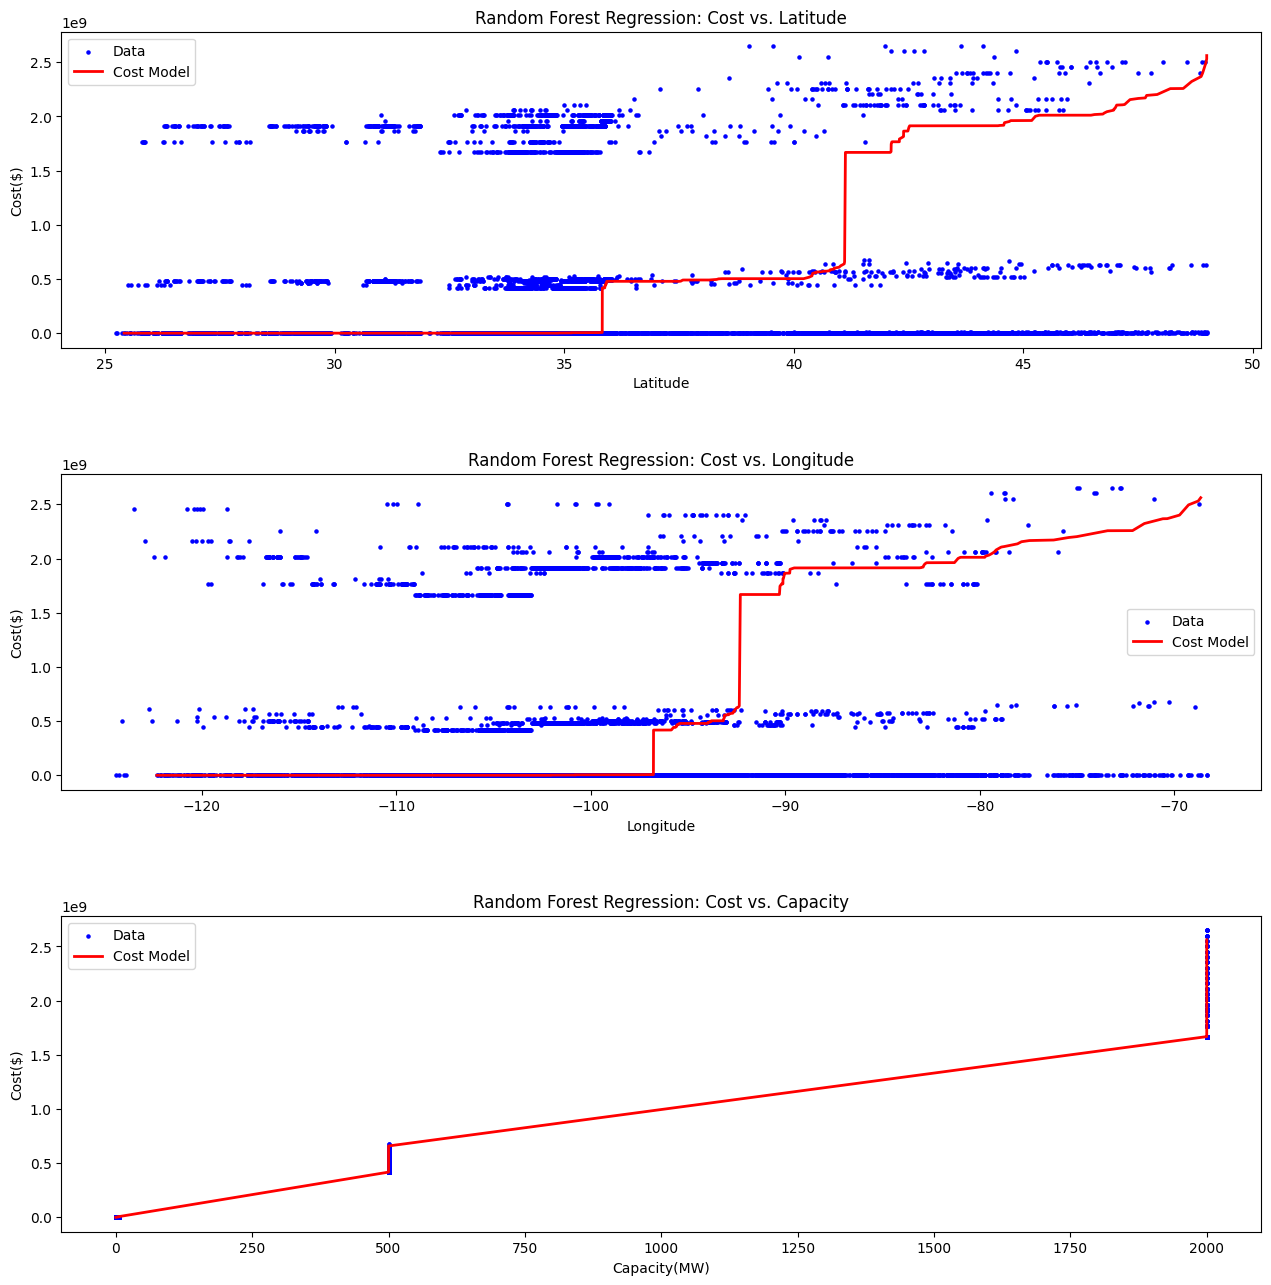

In [17]:
#| label: fig-cost-vs-input-features

plot_cost_y = pd.DataFrame(preds).loc[:,[1]].sort_values(by=[1])

figure, axis = plt.subplots(3)

figure.set_size_inches(15,15)

axis[0].scatter(X.loc[:,["lat"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[0].plot(plot_lat_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[0].set_xlabel("Latitude")
axis[0].set_ylabel("Cost($)")
axis[0].set_title("Random Forest Regression: Cost vs. Latitude")
axis[0].legend()

axis[1].scatter(X.loc[:,["long"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[1].plot(plot_long_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[1].set_xlabel("Longitude")
axis[1].set_ylabel("Cost($)")
axis[1].set_title("Random Forest Regression: Cost vs. Longitude")
axis[1].legend()

axis[2].scatter(X.loc[:,["capacity"]], y.loc[:,['cost']], color='blue', label='Data', s=5)
axis[2].plot(plot_cap_x, plot_cost_y, color='red',lw=2, label="Cost Model")
axis[2].set_xlabel("Capacity(MW)")
axis[2].set_ylabel("Cost($)")
axis[2].set_title("Random Forest Regression: Cost vs. Capacity")
axis[2].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.4, 
                    hspace=.4)

plt.show()

A graph of the feature importances. This helps to visualize the magnitude of importance of each feature, and compare their impact against one another.

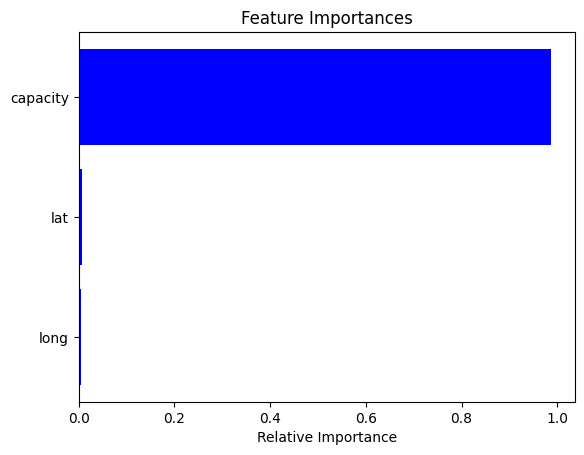

In [14]:
#| label: fig-feature-importances

plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

A graph of one of the decision trees in the random forest. This displays the decision making process the model takes to arive at predictions.

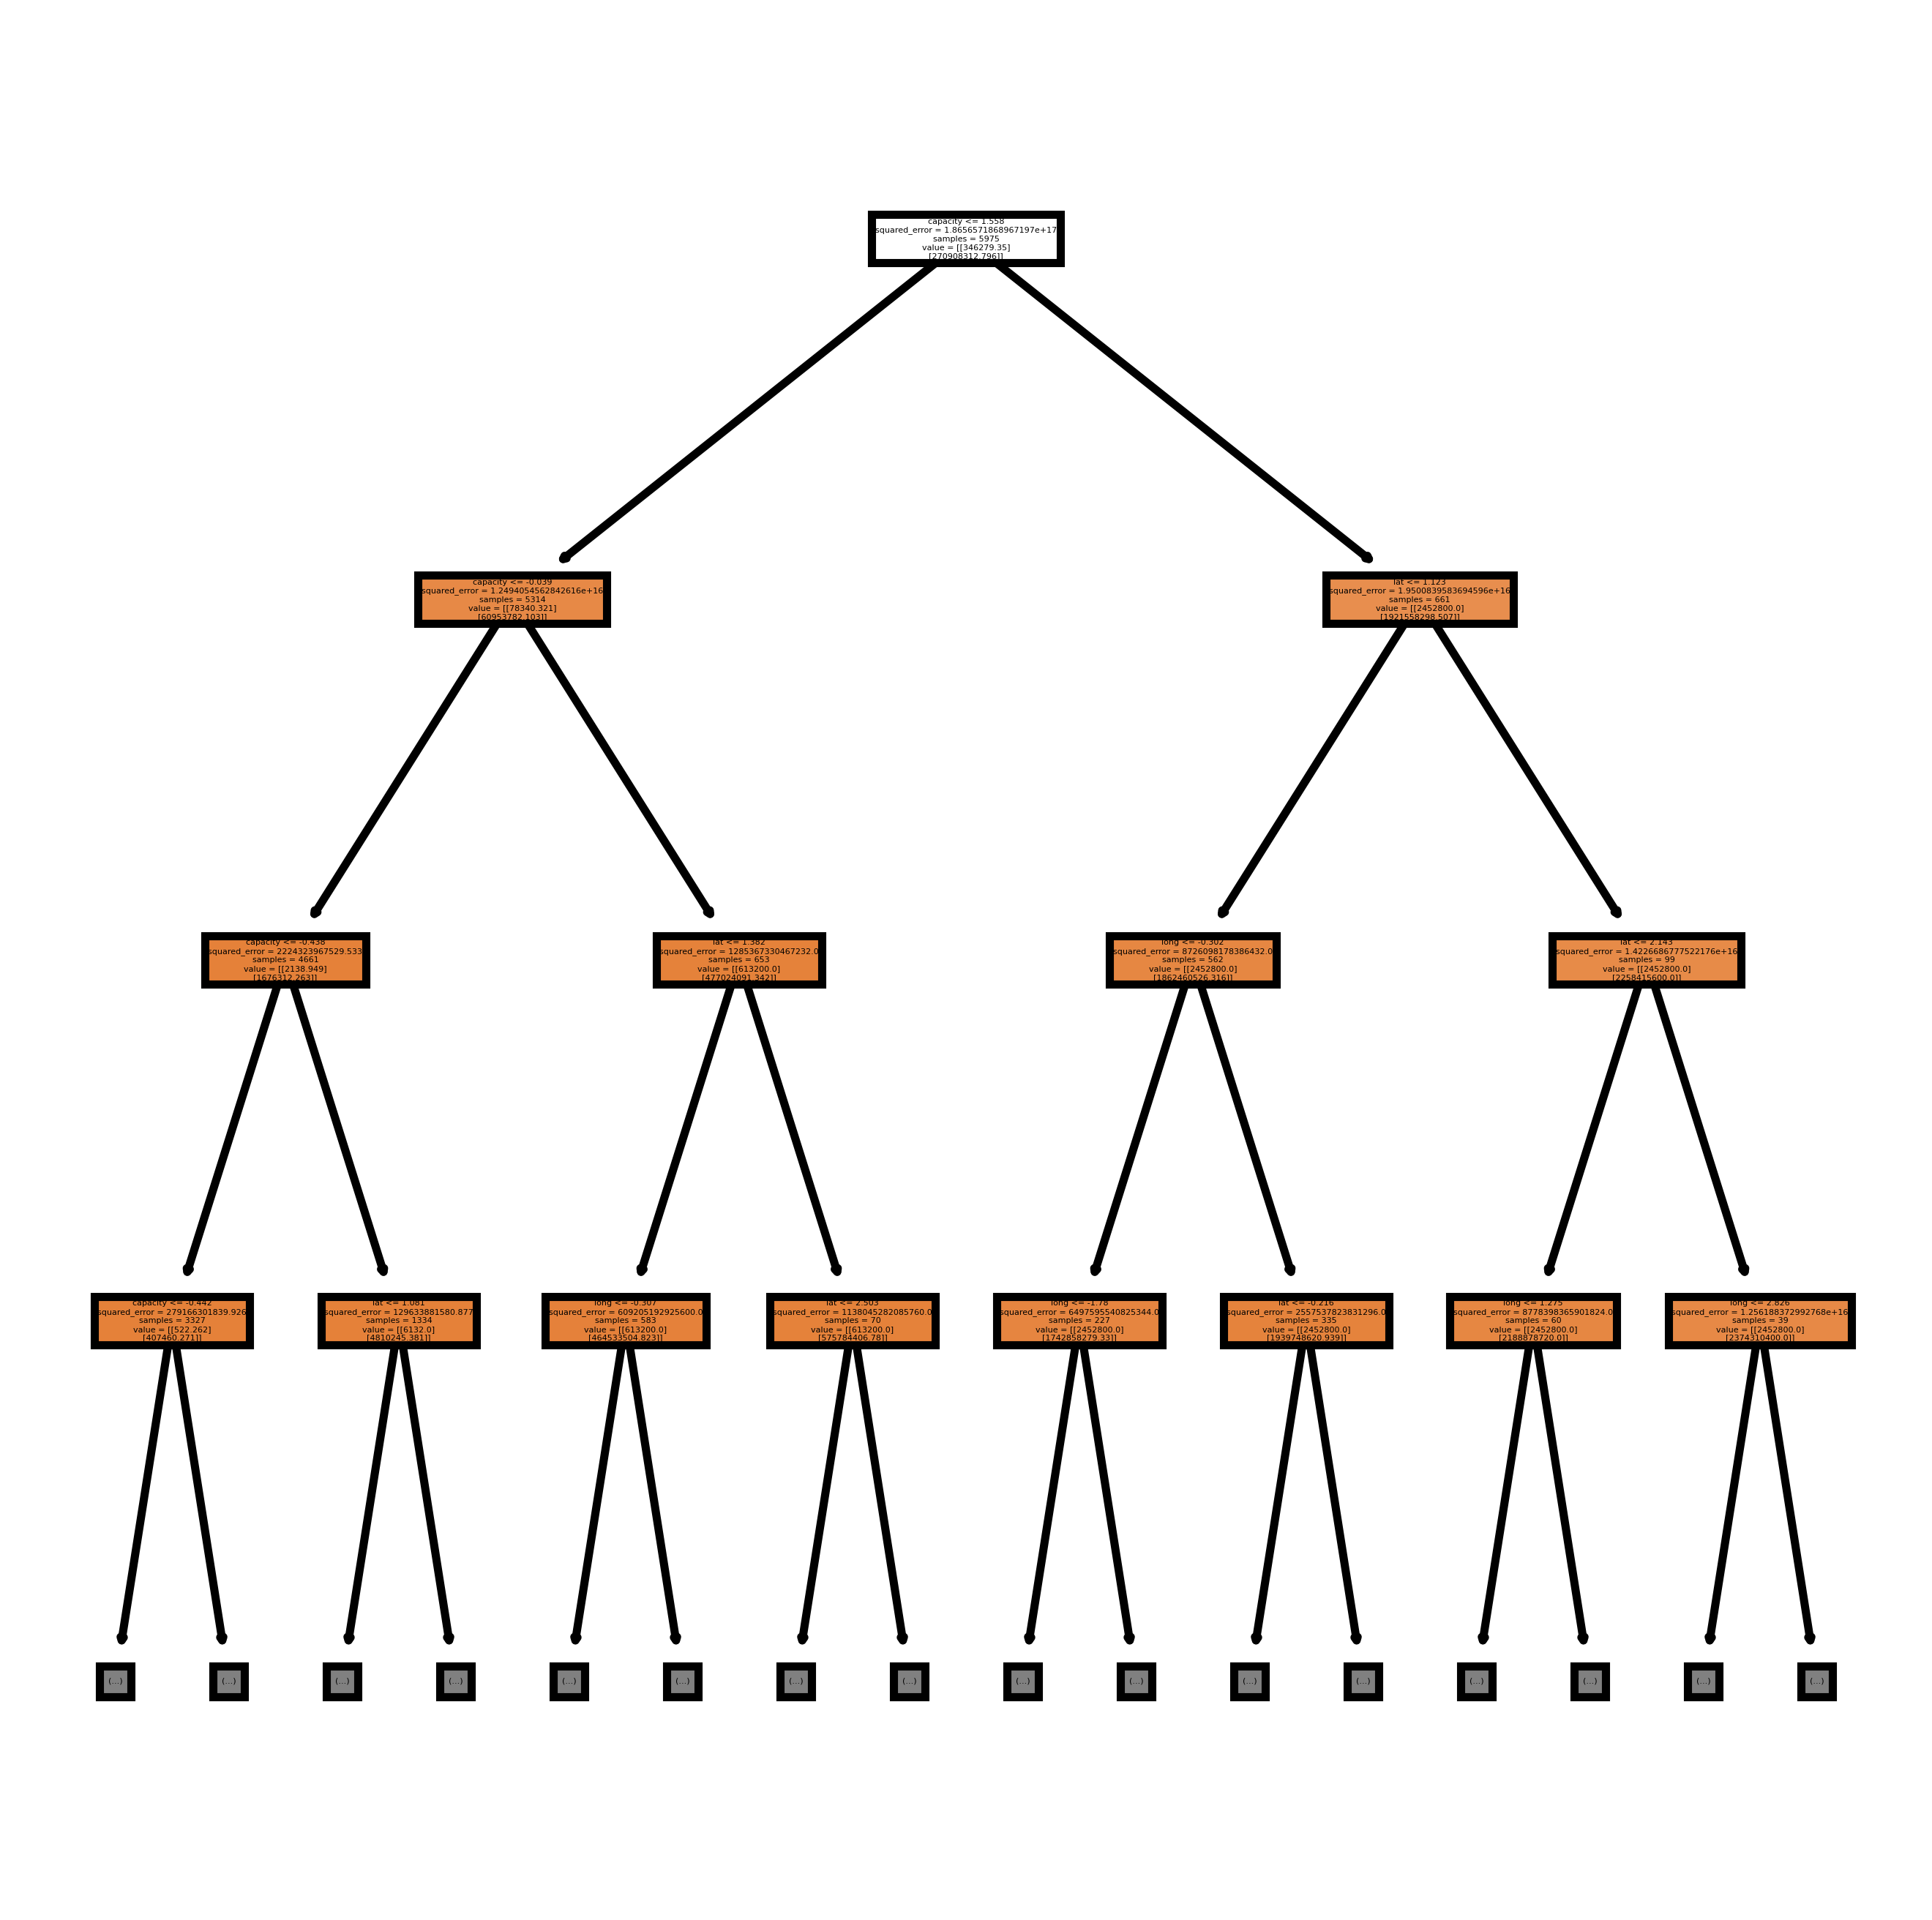

In [15]:
#| label: fig-decision-tree

fn = ['lat','long','capacity']
cn = ['generated_energy','cost']
plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=800)
tree.plot_tree(reg.estimators_[0],feature_names=fn,class_names=cn,filled=True, max_depth=3)
plt.show()